# SciZoom Tutorial: Dataset Exploration & LLM Inference

This notebook demonstrates:
1. **Loading SciZoom from HuggingFace**
2. **Data Exploration & Era Analysis**
3. **Hierarchical Summarization with vLLM**
4. **Embedding Analysis with NV-Embed-v2**
5. **Evaluation Metrics (ROUGE, BERTScore)**

## 0. Setup

In [1]:
# Install dependencies (uncomment if needed)
# !pip install datasets transformers torch vllm
# !pip install pandas numpy matplotlib seaborn
# !pip install rouge_score bert_score nltk

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Plot settings
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 12
sns.set_style('whitegrid')

print("Setup complete!")

Setup complete!


## 1. Load SciZoom from HuggingFace

In [3]:
from datasets import load_dataset

# Load dataset
print("Loading SciZoom from HuggingFace...")
dataset = load_dataset("hanjang/SciZoom")
print(f"Loaded {len(dataset['test']):,} papers")

# Convert to pandas for easier exploration
df = dataset["test"].to_pandas()
print(f"\nDataFrame shape: {df.shape}")
print(f"Columns: {list(df.columns)}")

Loading SciZoom from HuggingFace...
Loaded 44,946 papers

DataFrame shape: (44946, 23)
Columns: ['id', 'venue', 'year', 'type', 'title', 'abstract', 'tldr', 'keywords', 'authors', 'pdf_url', 'api_version', 'full_text', 'true_venue_full', 'accepted', 'contributions', 'contrib_source', 'contrib_count', 'primary_area', 'presentation_type', 'award', '_cleaning_method', '_chars_removed', 'era']


In [4]:
# Quick overview
print("=" * 60)
print("DATASET OVERVIEW")
print("=" * 60)

print(f"\nTotal papers: {len(df):,}")
print(f"\nVenue distribution:")
print(df['venue'].value_counts())

print(f"\nEra distribution:")
print(df['era'].value_counts())

print(f"\nYear range: {df['year'].min()} - {df['year'].max()}")
print(f"TL;DR available: {df['tldr'].notna().sum():,} ({df['tldr'].notna().mean()*100:.1f}%)")

DATASET OVERVIEW

Total papers: 44,946

Venue distribution:
venue
NeurIPS    18088
ICLR       17154
ICML        7695
EMNLP       2009
Name: count, dtype: int64

Era distribution:
era
post-llm    28192
pre-llm     16754
Name: count, dtype: int64

Year range: 2020 - 2025
TL;DR available: 21,298 (47.4%)


In [5]:
# Sample paper
sample = df.iloc[0]
print("=" * 60)
print("SAMPLE PAPER")
print("=" * 60)
print(f"\nTitle: {sample['title']}")
print(f"Venue: {sample['venue']} {sample['year']}")
print(f"Era: {sample['era']}")
print(f"\nAbstract ({len(sample['abstract'].split())} words):")
print(sample['abstract'][:500] + "...")
print(f"\nContributions ({len(sample['contributions'])} items):")
for i, c in enumerate(sample['contributions'][:3], 1):
    print(f"  {i}. {c[:100]}...")
print(f"\nTL;DR: {sample['tldr']}")

SAMPLE PAPER

Title: Learning to Learn by Zeroth-Order Oracle
Venue: ICLR 2020
Era: pre-llm

Abstract (159 words):
In the learning to learn (L2L) framework, we cast the design of optimization algorithms as a machine learning problem and use deep neural networks to learn the update rules. In this paper, we extend the L2L framework to zeroth-order (ZO) optimization setting, where no explicit gradient information is available. Our learned optimizer, modeled as recurrent neural network (RNN), first approximates gradient by ZO gradient estimator and then produces parameter update utilizing the knowledge of previo...

Contributions (3 items):
  1. We extend the L2L framework to ZO optimization setting and propose to use RNN to learn...
  2. Instead of using standard Gaussian sampling for random query directions as in traditional...
  3. Our learned optimizer leads to signiﬁcant improvement on some ZO optimization tasks (especially the ...

TL;DR: None


## 2. Era-based Analysis

In [6]:
# Split by era
df_pre = df[df['era'] == 'pre-llm']
df_post = df[df['era'] == 'post-llm']

print(f"Pre-LLM papers: {len(df_pre):,} ({len(df_pre)/len(df)*100:.1f}%)")
print(f"Post-LLM papers: {len(df_post):,} ({len(df_post)/len(df)*100:.1f}%)")

Pre-LLM papers: 16,754 (37.3%)
Post-LLM papers: 28,192 (62.7%)


In [7]:
# Text length comparison
def word_count(text):
    if pd.isna(text):
        return 0
    return len(str(text).split())

df['full_text_words'] = df['full_text'].apply(word_count)
df['abstract_words'] = df['abstract'].apply(word_count)

print("\nText Length Statistics:")
print("=" * 60)
for era, group in df.groupby('era'):
    print(f"\n{era.upper()}:")
    print(f"  Full text: {group['full_text_words'].mean():,.0f} ± {group['full_text_words'].std():,.0f} words")
    print(f"  Abstract: {group['abstract_words'].mean():.0f} ± {group['abstract_words'].std():.0f} words")


Text Length Statistics:

POST-LLM:
  Full text: 13,750 ± 5,632 words
  Abstract: 177 ± 40 words

PRE-LLM:
  Full text: 9,260 ± 3,767 words
  Abstract: 177 ± 44 words


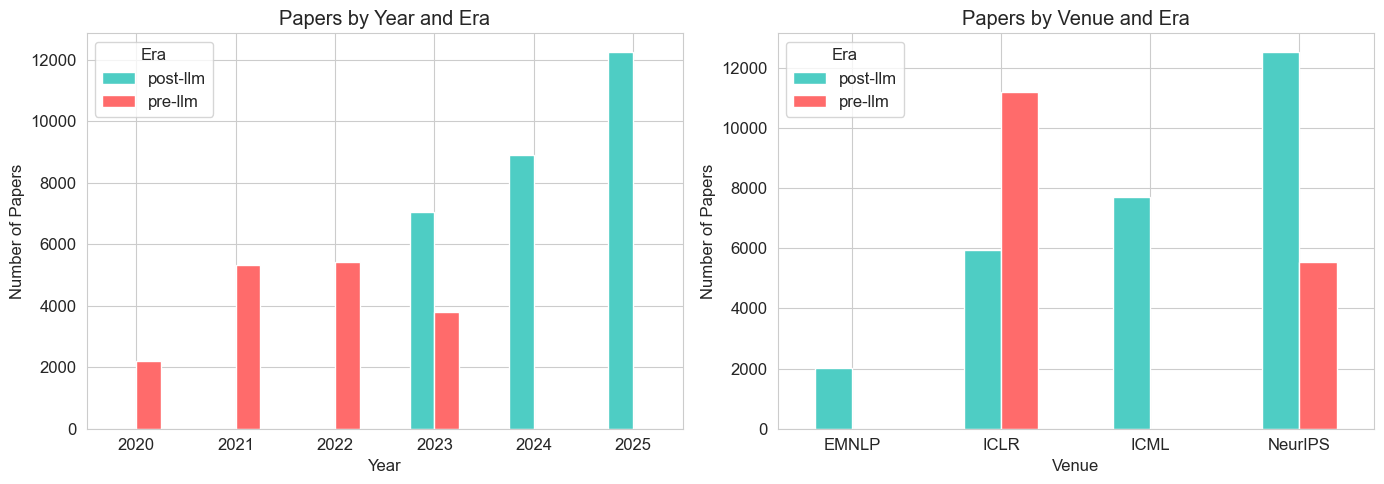

In [8]:
# Visualization: Papers by year and venue
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Papers by year
year_counts = df.groupby(['year', 'era']).size().unstack(fill_value=0)
year_counts.plot(kind='bar', ax=axes[0], color=['#4ECDC4', '#FF6B6B'])
axes[0].set_title('Papers by Year and Era')
axes[0].set_xlabel('Year')
axes[0].set_ylabel('Number of Papers')
axes[0].legend(title='Era')
axes[0].tick_params(axis='x', rotation=0)

# Papers by venue
venue_counts = df.groupby(['venue', 'era']).size().unstack(fill_value=0)
venue_counts.plot(kind='bar', ax=axes[1], color=['#4ECDC4', '#FF6B6B'])
axes[1].set_title('Papers by Venue and Era')
axes[1].set_xlabel('Venue')
axes[1].set_ylabel('Number of Papers')
axes[1].legend(title='Era')
axes[1].tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.savefig('era_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

## 3. Hierarchical Summarization with vLLM

Generate summaries at multiple granularity levels using vLLM for efficient inference.

In [9]:
# vLLM setup (requires GPU)
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"

from vllm import LLM, SamplingParams

# Initialize model
MODEL_NAME = "Qwen/Qwen2-7B-Instruct"
# Alternatives:
# - "meta-llama/Llama-3.1-8B-Instruct"
# - "mistralai/Mistral-7B-Instruct-v0.3"

print(f"Loading {MODEL_NAME}...")
llm = LLM(
    model=MODEL_NAME,
    tensor_parallel_size=2,
    gpu_memory_utilization=0.7,
    max_model_len=8192
)
print("Model loaded!")

Loading Qwen/Qwen2-7B-Instruct...
INFO 02-09 16:28:25 [utils.py:261] non-default args: {'max_model_len': 8192, 'tensor_parallel_size': 2, 'gpu_memory_utilization': 0.7, 'disable_log_stats': True, 'model': 'Qwen/Qwen2-7B-Instruct'}
INFO 02-09 16:28:26 [model.py:541] Resolved architecture: Qwen2ForCausalLM
INFO 02-09 16:28:26 [model.py:1561] Using max model len 8192


2026-02-09 16:28:26,778	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


INFO 02-09 16:28:26 [scheduler.py:226] Chunked prefill is enabled with max_num_batched_tokens=8192.
INFO 02-09 16:28:26 [vllm.py:624] Asynchronous scheduling is enabled.
(EngineCore_DP0 pid=1014355) INFO 02-09 16:28:28 [core.py:96] Initializing a V1 LLM engine (v0.15.1) with config: model='Qwen/Qwen2-7B-Instruct', speculative_config=None, tokenizer='Qwen/Qwen2-7B-Instruct', skip_tokenizer_init=False, tokenizer_mode=auto, revision=None, tokenizer_revision=None, trust_remote_code=False, dtype=torch.bfloat16, max_seq_len=8192, download_dir=None, load_format=auto, tensor_parallel_size=2, pipeline_parallel_size=1, data_parallel_size=1, disable_custom_all_reduce=False, quantization=None, enforce_eager=False, enable_return_routed_experts=False, kv_cache_dtype=auto, device_config=cuda, structured_outputs_config=StructuredOutputsConfig(backend='auto', disable_fallback=False, disable_any_whitespace=False, disable_additional_properties=False, reasoning_parser='', reasoning_parser_plugin='', enabl

[W209 16:28:30.857678219 socket.cpp:767] [c10d] The client socket cannot be initialized to connect to [localhost]:56771 (errno: 97 - Address family not supported by protocol).
[W209 16:28:30.865760107 socket.cpp:767] [c10d] The client socket cannot be initialized to connect to [localhost]:56771 (errno: 97 - Address family not supported by protocol).


[Gloo] Rank 0 is connected to 1 peer ranks. Expected number of connected peer ranks is : 1
[Gloo] Rank 1 is connected to 1 peer ranks. Expected number of connected peer ranks is : 1
[Gloo] Rank 1 is connected to 1 peer ranks. Expected number of connected peer ranks is : 1
[Gloo] Rank 0 is connected to 1 peer ranks. Expected number of connected peer ranks is : 1
[Gloo] Rank 0 is connected to 0 peer ranks. Expected number of connected peer ranks is : 0
[Gloo] Rank 0 is connected to 0 peer ranks. Expected number of connected peer ranks is : 0
[Gloo] Rank 0 is connected to 0 peer ranks. Expected number of connected peer ranks is : 0
[Gloo] Rank 0 is connected to 0 peer ranks. Expected number of connected peer ranks is : 0
[Gloo] Rank 0 is connected to 0 peer ranks. Expected number of connected peer ranks is : 0
[Gloo] Rank 0 is connected to 0 peer ranks. Expected number of connected peer ranks is : 0
[Gloo] Rank 0 is connected to 0 peer ranks. Expected number of connected peer ranks is : 0

Loading safetensors checkpoint shards:   0% Completed | 0/4 [00:00<?, ?it/s];0m 
Loading safetensors checkpoint shards:  25% Completed | 1/4 [00:00<00:01,  2.07it/s]
Loading safetensors checkpoint shards:  50% Completed | 2/4 [00:00<00:01,  2.00it/s]
Loading safetensors checkpoint shards:  75% Completed | 3/4 [00:01<00:00,  2.02it/s]
Loading safetensors checkpoint shards: 100% Completed | 4/4 [00:02<00:00,  1.97it/s]
Loading safetensors checkpoint shards: 100% Completed | 4/4 [00:02<00:00,  1.99it/s]
(EngineCore_DP0 pid=1014355) (Worker_TP0 pid=1014369) 


(EngineCore_DP0 pid=1014355) (Worker_TP0 pid=1014369) INFO 02-09 16:28:35 [default_loader.py:291] Loading weights took 2.10 seconds
(EngineCore_DP0 pid=1014355) (Worker_TP0 pid=1014369) INFO 02-09 16:28:35 [gpu_model_runner.py:4130] Model loading took 7.12 GiB memory and 4.038182 seconds
(EngineCore_DP0 pid=1014355) (Worker_TP0 pid=1014369) INFO 02-09 16:28:39 [backends.py:812] Using cache directory: /home/hjang/.cache/vllm/torch_compile_cache/54f987c09b/rank_0_0/backbone for vLLM's torch.compile
(EngineCore_DP0 pid=1014355) (Worker_TP0 pid=1014369) INFO 02-09 16:28:39 [backends.py:872] Dynamo bytecode transform time: 3.47 s
(EngineCore_DP0 pid=1014355) (Worker_TP1 pid=1014371) INFO 02-09 16:28:41 [backends.py:302] Cache the graph of compile range (1, 8192) for later use
(EngineCore_DP0 pid=1014355) (Worker_TP0 pid=1014369) INFO 02-09 16:28:41 [backends.py:302] Cache the graph of compile range (1, 8192) for later use
(EngineCore_DP0 pid=1014355) (Worker_TP0 pid=1014369) INFO 02-09 16:2

Capturing CUDA graphs (mixed prefill-decode, PIECEWISE): 100%|██████████| 51/51 [00:03<00:00, 16.72it/s]
Capturing CUDA graphs (decode, FULL): 100%|██████████| 35/35 [00:01<00:00, 24.90it/s]


(EngineCore_DP0 pid=1014355) (Worker_TP0 pid=1014369) INFO 02-09 16:28:49 [gpu_model_runner.py:5063] Graph capturing finished in 5 secs, took 1.11 GiB
(EngineCore_DP0 pid=1014355) INFO 02-09 16:28:49 [core.py:272] init engine (profile, create kv cache, warmup model) took 14.22 seconds
INFO 02-09 16:28:52 [llm.py:343] Supported tasks: ['generate']
Model loaded!


In [10]:
# Prompt templates for each granularity
PROMPTS = {
    "abstract": """Summarize the following scientific paper as an abstract (150-200 words):

{full_text}

Abstract:""",
    
    "contributions": """Extract the key contributions from this paper as a bullet-point list (3-5 items):

{full_text}

Key Contributions:""",
    
    "tldr": """Write a one-sentence TL;DR summary (max 30 words) for this paper:

{full_text}

TL;DR:"""
}

# Sampling parameters
SAMPLING_PARAMS = {
    "abstract": SamplingParams(temperature=0, max_tokens=512),
    "contributions": SamplingParams(temperature=0, max_tokens=512),
    "tldr": SamplingParams(temperature=0, max_tokens=64)
}

In [11]:
def generate_summaries(paper, llm, max_input_len=6000):
    """Generate summaries at all granularity levels."""
    results = {}
    
    # Truncate full text if needed
    full_text = paper['full_text'][:max_input_len]
    
    for task, prompt_template in PROMPTS.items():
        prompt = prompt_template.format(full_text=full_text)
        output = llm.generate([prompt], SAMPLING_PARAMS[task])
        results[task] = output[0].outputs[0].text.strip()
    
    return results

In [12]:
# Generate summaries for sample paper
sample_paper = df.iloc[0].to_dict()

print("Generating summaries...")
generated = generate_summaries(sample_paper, llm)

print("\n" + "=" * 60)
print("GENERATED SUMMARIES")
print("=" * 60)

print(f"\n[ABSTRACT]\n{generated['abstract']}")
print(f"\n[CONTRIBUTIONS]\n{generated['contributions']}")
print(f"\n[TL;DR]\n{generated['tldr']}")

print("\n" + "=" * 60)
print("GROUND TRUTH")
print("=" * 60)
print(f"\n[ABSTRACT]\n{sample_paper['abstract'][:500]}...")
print(f"\n[CONTRIBUTIONS]\n" + "\n".join([f"- {c}" for c in sample_paper['contributions']]))
print(f"\n[TL;DR]\n{sample_paper['tldr']}")

Generating summaries...


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.82s/it, est. speed input: 793.04 toks/s, output: 35.22 toks/s]


GENERATED SUMMARIES

[ABSTRACT]
This paper introduces a novel approach to learning to learn (L2L) by utilizing zeroth-order (ZO) oracles, which are optimization problems where only function values are available, not gradients. The authors propose a method to learn ZO update rules using recurrent neural networks (RNNs) and introduce a technique to adaptively modify the search distribution for random query directions. This leads to faster convergence and lower final loss compared to hand-designed ZO algorithms. The learned optimizer is shown to significantly improve performance on ZO optimization tasks, particularly in black-box adversarial attacks on deep neural networks. The paper also includes extensive experiments to analyze the effectiveness of the learned optimizer.

Keywords: Learning to Learn, Zeroth-Order Optimization, Recurrent Neural Networks, Meta-Learning, Black-Box Adversarial Attacks

The paper addresses the challenge of learning optimization algorithms in scenarios where

## Summary

This tutorial demonstrated:
1. Loading SciZoom dataset from HuggingFace
2. Era-based data exploration
3. Hierarchical summarization with vLLM (Abstract, Contributions, TL;DR)
4. Semantic similarity analysis with NV-Embed-v2
5. Evaluation with ROUGE and BERTScore

For more details on the contribution extraction pipeline and linguistic analysis, please refer to our paper.